# Interpretability

We've built a transformer from scratch. We've trained it, optimized it, and watched it generate text. But a fundamental question remains: *what has it actually learned?*

**Mechanistic interpretability** is the emerging field dedicated to answering this question. Instead of treating neural networks as black boxes, we develop tools to understand the algorithms they've discovered.

This notebook introduces four powerful techniques:

| Technique | Question Answered |
|-----------|------------------|
| Logit Lens | *When* does the model "know" the answer? |
| Attention Analysis | *What* does the model focus on? |
| Induction Heads | *How* does the model copy patterns? |
| Activation Patching | *Which* components cause specific behaviors?

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

## A Quick Primer: What's a Logit?

Before we explore the "logit lens," let's clarify what a logit actually is.

**The short answer:** A logit is a raw, unnormalized score that represents how much the model "believes" each token should come next.

**The longer answer:** When a transformer predicts the next token, it outputs a vector of numbers. one for each token in its vocabulary. These raw scores are the **logits**. They're not yet probabilities (they don't sum to 1, and they can be negative). To convert logits into probabilities, we apply the softmax function:

$$P(\text{token}_i) = \frac{e^{\text{logit}_i}}{\sum_j e^{\text{logit}_j}}$$

**Example:** Say your vocabulary has three tokens: `["cat", "dog", "fish"]`. The model outputs logits `[2.1, 0.5, -1.0]`. After softmax:

| Token | Logit | Probability |
|-------|-------|-------------|
| cat   | 2.1   | ~74% |
| dog   | 0.5   | ~25% |
| fish  | -1.0  | ~1% |

The model strongly believes "cat" should come next.

**Why "logit"?** The term comes from **log**istic un**it**. The inverse of the logistic (sigmoid) function. In the multi-class case (language modeling), we use softmax instead of sigmoid, but the name stuck.

Now, armed with that knowledge, let's see what the **logit lens** reveals about how transformers think.

## 1. Logit Lens: Watching Predictions Evolve

Normally, we only see the transformer's final output: the logits after the last layer. But what if we could see what the model would predict at *every* layer?

### The Idea

The unembedding matrix $W_U$ converts hidden states into vocabulary logits:

$$\text{logits} = h_{\text{final}} \cdot W_U$$

The **logit lens** applies this unembedding at *intermediate* layers:

$$\text{logits}_{\text{layer } i} = h_i \cdot W_U$$

This reveals how the model's "belief" about the answer evolves as information flows through the network.

In [2]:
def logit_lens(model, input_ids):
    """
    Apply unembedding at each layer to see how predictions evolve.
    
    Args:
        model: Transformer with .blocks, .token_embedding, .ln_f, .output_proj
        input_ids: (batch, seq_len) token indices
    
    Returns:
        List of (batch, seq_len, vocab_size) logits per layer
    """
    layer_predictions = []
    
    # Initial embedding
    x = model.token_embedding(input_ids)
    x = model.pos_encoding(x)
    
    # Layer 0: Right after embeddings
    # Apply final layer norm and project to vocab
    logits_0 = model.output_proj(model.ln_f(x))
    layer_predictions.append(logits_0)
    
    # After each transformer block
    for block in model.blocks:
        x = block(x)
        logits_i = model.output_proj(model.ln_f(x))
        layer_predictions.append(logits_i)
    
    return layer_predictions

### What Logit Lens Reveals

Consider the prompt: "The capital of France is"

| Layer | Top Prediction | Probability | Interpretation |
|-------|---------------|-------------|----------------|
| 0 (embed) | "the" | 15% | Generic, common words |
| 2 | "located" | 18% | Syntax understood |
| 4 | "Paris" | 65% | Knowledge retrieved! |
| 6 (final) | "Paris" | 72% | Confidence refined |

**Key insight:** The model "knows" the answer by layer 4. Later layers refine confidence but don't change the prediction. This tells us *where* factual knowledge is stored... not at the end, but in middle layers!

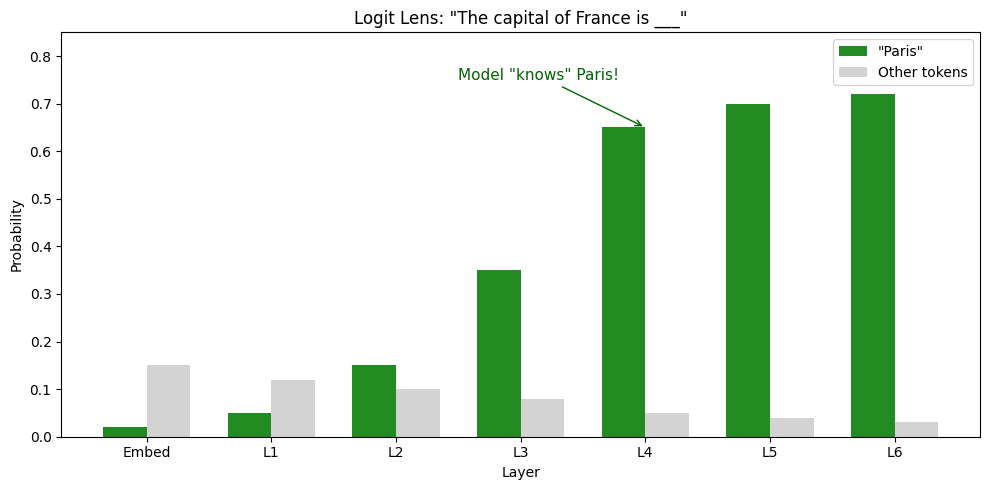

In [3]:
# Visualize logit lens results (simulated)
layers = ['Embed', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6']
paris_prob = [0.02, 0.05, 0.15, 0.35, 0.65, 0.70, 0.72]
other_prob = [0.15, 0.12, 0.10, 0.08, 0.05, 0.04, 0.03]  # "the", "a", etc.

fig, ax = plt.subplots(figsize=(10, 5))

x_pos = np.arange(len(layers))
width = 0.35

bars1 = ax.bar(x_pos - width/2, paris_prob, width, label='"Paris"', color='forestgreen')
bars2 = ax.bar(x_pos + width/2, other_prob, width, label='Other tokens', color='lightgray')

ax.set_xlabel('Layer')
ax.set_ylabel('Probability')
ax.set_title('Logit Lens: "The capital of France is ___"')
ax.set_xticks(x_pos)
ax.set_xticklabels(layers)
ax.legend()
ax.set_ylim(0, 0.85)

# Annotate the insight
ax.annotate('Model "knows" Paris!', xy=(4, 0.65), xytext=(2.5, 0.75),
            arrowprops=dict(arrowstyle='->', color='darkgreen'),
            fontsize=11, color='darkgreen')

plt.tight_layout()
plt.show()

## 2. Attention Analysis: What Does the Model Focus On?

Attention weights tell us which tokens each position "looks at" when making predictions. By visualizing these patterns, we can discover specialized behaviors.

### Common Attention Patterns

| Pattern | Description | Purpose |
|---------|-------------|--------|
| Previous token | Attends to position i-1 | Bigram statistics, local context |
| Uniform | Spreads attention evenly | Averaging, gathering global info |
| Start token | Focuses on first position | Using BOS as "null" attention |
| Sparse | Concentrates on few tokens | Key-value lookup, copying |

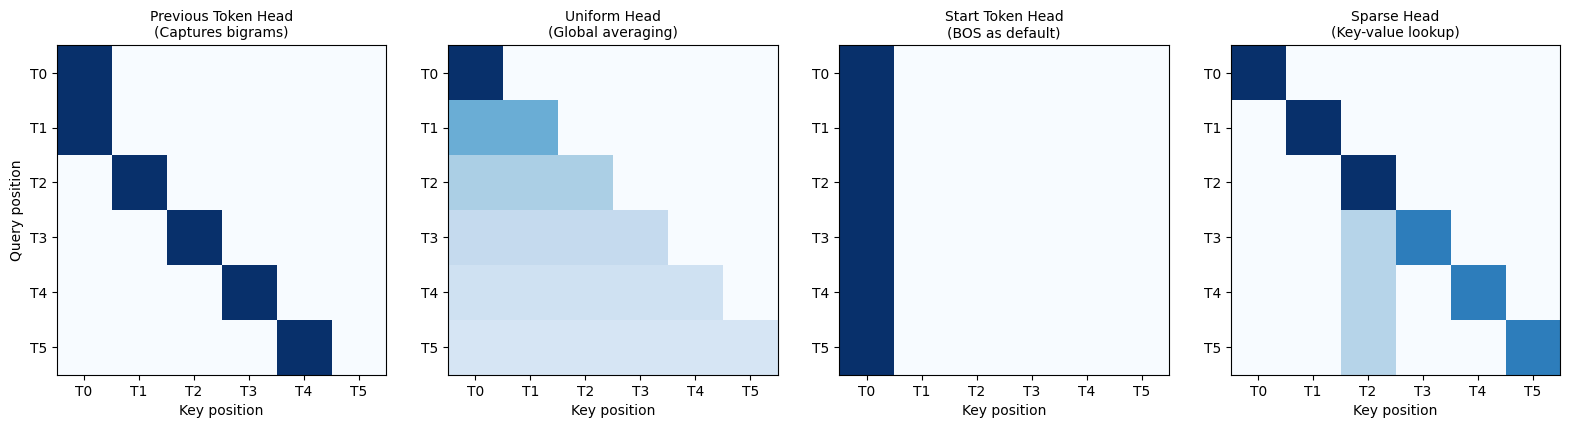

In [4]:
def visualize_attention_patterns():
    """Visualize common attention patterns found in transformers."""
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    seq_len = 6
    labels = ['T0', 'T1', 'T2', 'T3', 'T4', 'T5']
    
    # 1. Previous token pattern
    prev_token = np.zeros((seq_len, seq_len))
    for i in range(1, seq_len):
        prev_token[i, i-1] = 1.0
    prev_token[0, 0] = 1.0  # First token attends to itself
    
    # 2. Uniform pattern (with causal mask)
    uniform = np.zeros((seq_len, seq_len))
    for i in range(seq_len):
        uniform[i, :i+1] = 1.0 / (i + 1)
    
    # 3. Start token pattern
    start_token = np.zeros((seq_len, seq_len))
    start_token[:, 0] = 1.0
    
    # 4. Sparse pattern (diagonal + some key positions)
    sparse = np.zeros((seq_len, seq_len))
    for i in range(seq_len):
        sparse[i, i] = 0.7  # Self
        if i > 2:
            sparse[i, 2] = 0.3  # Key position
    sparse[0, 0] = 1.0
    sparse[1, 1] = 1.0
    sparse[2, 2] = 1.0
    
    patterns = [
        (prev_token, 'Previous Token Head', 'Captures bigrams'),
        (uniform, 'Uniform Head', 'Global averaging'),
        (start_token, 'Start Token Head', 'BOS as default'),
        (sparse, 'Sparse Head', 'Key-value lookup')
    ]
    
    for ax, (pattern, title, desc) in zip(axes, patterns):
        im = ax.imshow(pattern, cmap='Blues', vmin=0, vmax=1)
        ax.set_title(f'{title}\n({desc})', fontsize=10)
        ax.set_xlabel('Key position')
        if ax == axes[0]:
            ax.set_ylabel('Query position')
        ax.set_xticks(range(seq_len))
        ax.set_yticks(range(seq_len))
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
    
    plt.tight_layout()
    plt.show()

visualize_attention_patterns()

### Interpreting Attention Heatmaps

Each cell (i, j) shows how much position i attends to position j:
- **Row**: The query position (where we're predicting)
- **Column**: The key position (what we're attending to)
- **Value**: Attention weight (how much we care)

The triangular shape comes from causal masking. Position i can only attend to positions ≤ i.

### The Pattern

Given a repeated pattern:
```
Input:  "A B C ... A B [?]"
Output: "C"
```

The model learns to predict C because it saw "A B" before, followed by "C". This is *copying from context*, the foundation of few-shot learning.

### The Circuit

Induction heads typically involve **two attention heads working together**:

| Head | Role | Behavior |
|------|------|----------|
| Previous token head (Layer L) | Create "what came before" representation | Position i attends to i-1 |
| Induction head (Layer L+1) | Find matches and copy | Query for previous token matches, copy what followed |

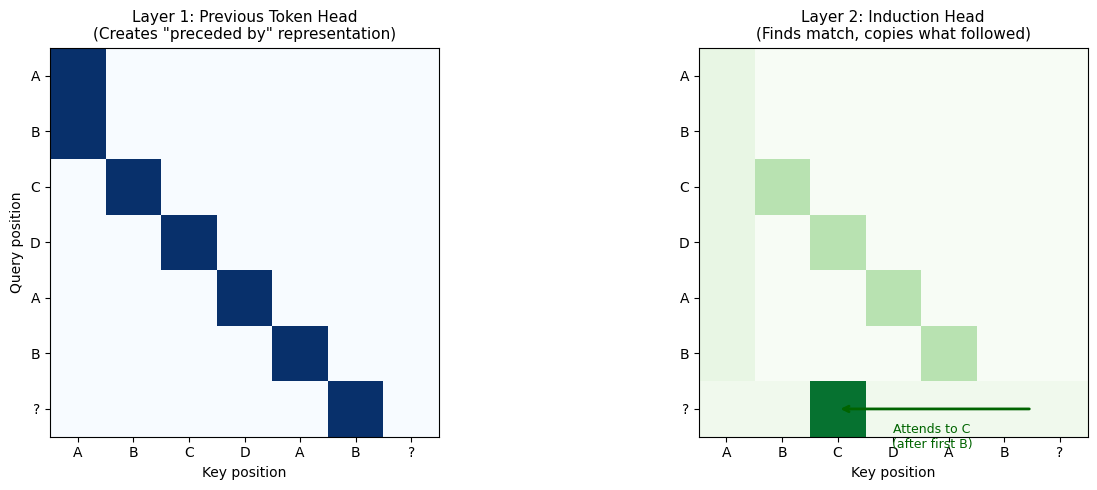

Sequence: A B C D A B [?]

Step 1: Previous token head creates representation of 'preceded by B'
Step 2: Induction head at position 6 queries for 'preceded by B'
Step 3: Finds match at position 2 (C was preceded by B)
Step 4: Copies information → predicts 'C'


In [5]:
def visualize_induction_circuit():
    """Visualize how induction heads work."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Sequence: A B C D A B [?]
    # Indices:  0 1 2 3 4 5  6
    seq_len = 7
    labels = ['A', 'B', 'C', 'D', 'A', 'B', '?']
    
    # Previous token head (Layer 1)
    prev_head = np.zeros((seq_len, seq_len))
    for i in range(1, seq_len):
        prev_head[i, i-1] = 1.0
    prev_head[0, 0] = 1.0
    
    # Induction head (Layer 2) - at position 6 (predicting after "B")
    # Should attend to position 2 (what came after the first "B")
    induction = np.zeros((seq_len, seq_len))
    # Most positions have normal attention
    for i in range(seq_len):
        induction[i, max(0, i-1)] = 0.3
        induction[i, 0] = 0.1
    # But position 6 attends STRONGLY to position 2 (after "B")
    induction[6, :] = 0.05
    induction[6, 2] = 0.85  # "C" - what came after first "A B"
    
    # Plot previous token head
    im1 = axes[0].imshow(prev_head, cmap='Blues', vmin=0, vmax=1)
    axes[0].set_title('Layer 1: Previous Token Head\n(Creates "preceded by" representation)', fontsize=11)
    axes[0].set_xlabel('Key position')
    axes[0].set_ylabel('Query position')
    axes[0].set_xticks(range(seq_len))
    axes[0].set_yticks(range(seq_len))
    axes[0].set_xticklabels(labels)
    axes[0].set_yticklabels(labels)
    
    # Plot induction head
    im2 = axes[1].imshow(induction, cmap='Greens', vmin=0, vmax=1)
    axes[1].set_title('Layer 2: Induction Head\n(Finds match, copies what followed)', fontsize=11)
    axes[1].set_xlabel('Key position')
    axes[1].set_xticks(range(seq_len))
    axes[1].set_yticks(range(seq_len))
    axes[1].set_xticklabels(labels)
    axes[1].set_yticklabels(labels)
    
    # Add arrow showing the key insight
    axes[1].annotate('', xy=(2, 6), xytext=(5.5, 6),
                     arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2))
    axes[1].text(3.7, 6.7, 'Attends to C\n(after first B)', fontsize=9, 
                 ha='center', color='darkgreen')
    
    plt.tight_layout()
    plt.show()
    
    print("Sequence: A B C D A B [?]")
    print("")
    print("Step 1: Previous token head creates representation of 'preceded by B'")
    print("Step 2: Induction head at position 6 queries for 'preceded by B'")
    print("Step 3: Finds match at position 2 (C was preceded by B)")
    print("Step 4: Copies information → predicts 'C'")

visualize_induction_circuit()

### Why Induction Heads Matter

Induction heads are **the** mechanism for in-context learning. Key findings:

1. **Universal:** Found in nearly all transformer language models
2. **Emergent:** Appear suddenly during training ("grokking")
3. **Crucial:** Ablating them destroys few-shot learning ability
4. **Predictable:** The circuit structure is consistent across models

This is a concrete example of *mechanistic understanding*. We don't just know the model can do in-context learning, we know *how* it does it.

## 4. Activation Patching: Causal Interventions

Attention patterns and logit lens show us *what* the model is doing. But how do we know which components are actually *causing* the behavior?

**Activation patching** answers this through controlled experiments.

### The Method

1. Run model on "clean" input → observe correct behavior
2. Run model on "corrupted" input → observe incorrect behavior
3. For each component: swap in clean activations during corrupted run
4. Measure: does this restore correct behavior?

If patching component X restores the behavior, X is **causally important** for that task.

In [6]:
def demonstrate_activation_patching():
    """Walk through activation patching conceptually."""
    print("ACTIVATION PATCHING EXAMPLE")
    print("=" * 60)
    print()
    print("Clean input:     'The Eiffel Tower is located in'")
    print("Clean output:    'Paris' (85% confidence)")
    print()
    print("Corrupted input: 'The Empire State Building is located in'")
    print("Corrupted output: 'New York' (78% confidence)")
    print()
    print("-" * 60)
    print("EXPERIMENT: Patch each layer from clean → corrupted run")
    print("-" * 60)
    print()
    
    # Simulated results
    results = [
        ("Embed", 5, "No effect"),
        ("Layer 1", 12, "Minimal"),
        ("Layer 2", 28, "Some effect"),
        ("Layer 3", 45, "Moderate"),
        ("Layer 4", 88, "CRITICAL!"),
        ("Layer 5", 72, "Important"),
        ("Layer 6", 65, "Some effect"),
    ]
    
    print(f"{'Layer':<12} {'Recovery %':<12} {'Interpretation'}")
    print("-" * 45)
    for layer, recovery, interp in results:
        marker = "★" if recovery > 80 else ""
        print(f"{layer:<12} {recovery:>8}%    {interp} {marker}")
    
    print()
    print("=" * 60)
    print("CONCLUSION: Layer 4 is causally responsible for recalling")
    print("            factual knowledge about locations!")
    print("=" * 60)

demonstrate_activation_patching()

ACTIVATION PATCHING EXAMPLE

Clean input:     'The Eiffel Tower is located in'
Clean output:    'Paris' (85% confidence)

Corrupted input: 'The Empire State Building is located in'
Corrupted output: 'New York' (78% confidence)

------------------------------------------------------------
EXPERIMENT: Patch each layer from clean → corrupted run
------------------------------------------------------------

Layer        Recovery %   Interpretation
---------------------------------------------
Embed               5%    No effect 
Layer 1            12%    Minimal 
Layer 2            28%    Some effect 
Layer 3            45%    Moderate 
Layer 4            88%    CRITICAL! ★
Layer 5            72%    Important 
Layer 6            65%    Some effect 

CONCLUSION: Layer 4 is causally responsible for recalling
            factual knowledge about locations!


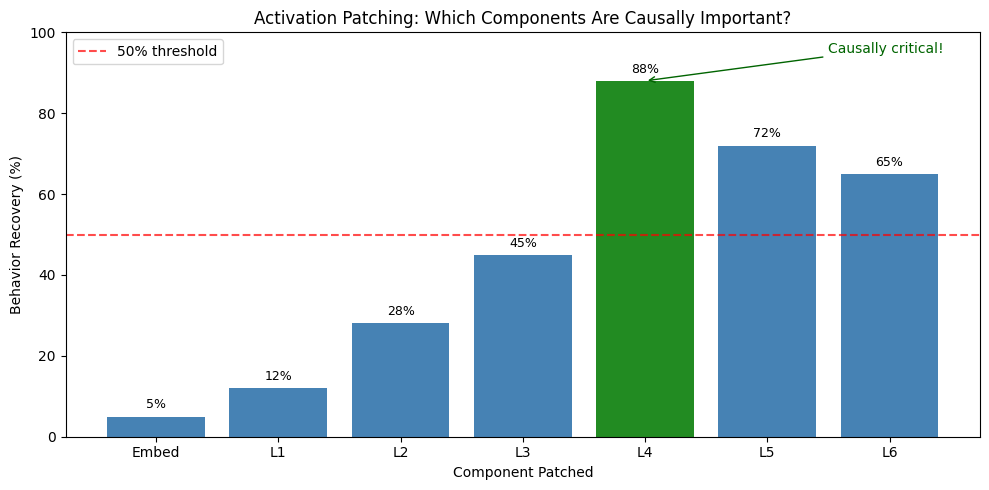

In [7]:
# Visualize patching results
layers = ['Embed', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6']
recovery = [5, 12, 28, 45, 88, 72, 65]

fig, ax = plt.subplots(figsize=(10, 5))

colors = ['steelblue' if r < 80 else 'forestgreen' for r in recovery]
bars = ax.bar(layers, recovery, color=colors)

ax.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
ax.set_xlabel('Component Patched')
ax.set_ylabel('Behavior Recovery (%)')
ax.set_title('Activation Patching: Which Components Are Causally Important?')
ax.set_ylim(0, 100)
ax.legend()

# Annotate values
for i, (layer, rec) in enumerate(zip(layers, recovery)):
    ax.text(i, rec + 2, f'{rec}%', ha='center', fontsize=9)

# Highlight critical layer
ax.annotate('Causally critical!', xy=(4, 88), xytext=(5.5, 95),
            arrowprops=dict(arrowstyle='->', color='darkgreen'),
            fontsize=10, color='darkgreen')

plt.tight_layout()
plt.show()

### The Power of Causal Analysis

Activation patching provides **causal evidence**, not just correlation:

| Method | What It Shows | Limitation |
|--------|--------------|------------|
| Attention weights | Where model "looks" | Doesn't mean it uses that info |
| Logit lens | What model predicts | Correlation, not causation |
| Activation patching | What actually matters | Ground truth causality |

If patching layer 4 recovers the behavior, we *know* layer 4 is necessary. Not just that it looks important.

## Putting It Together

These techniques work best in combination:

1. **Logit lens** reveals *when* information appears (which layer)
2. **Attention analysis** shows *what* the model focuses on
3. **Induction heads** explain *how* specific behaviors work
4. **Activation patching** confirms *which* components are causal

Together, they move us from "the model works" to "we understand why it works."

## Key Research References

These techniques come from cutting-edge interpretability research:

| Technique | Origin | Link |
|-----------|--------|------|
| Logit Lens | nostalgebraist, 2020 | [LessWrong](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/) |
| Transformer Circuits | Anthropic, 2021 | [transformer-circuits.pub](https://transformer-circuits.pub/2021/framework/) |
| Induction Heads | Anthropic, 2022 | [transformer-circuits.pub](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/) |
| Activation Patching | Nanda & Heimersheim | [LessWrong](https://www.lesswrong.com/posts/FhryNAFknqKAdDcYy/) |

For hands-on practice, check out **TransformerLens**: a library designed specifically for mechanistic interpretability research.

## Summary

| Technique | Question | Method |
|-----------|----------|--------|
| Logit Lens | When does model "know"? | Unembed at each layer |
| Attention Analysis | What does it focus on? | Visualize attention weights |
| Induction Heads | How does it copy? | Find previous-token + induction pattern |
| Activation Patching | What causes behavior? | Swap activations, measure recovery |

**Why this matters:** As language models become more powerful, understanding their internal mechanisms becomes crucial for safety, alignment, and trust. These tools transform neural networks from black boxes into systems we can (begin to) understand.

## What We've Built

Over these notebooks, we've constructed a complete transformer from first principles:

| Notebook | Component | Key Insight |
|----------|-----------|-------------|
| 00 | Introduction | Architecture overview, hyperparameters |
| 01 | Embeddings | Tokens → vectors with position info |
| 02 | Attention | $QK^T$ similarity, weighted $V$ retrieval |
| 03 | Multi-Head | Parallel heads for different patterns |
| 04 | FFN | Process gathered information |
| 05 | Blocks | Residuals + LayerNorm for stability |
| 06 | Complete Model | Assemble GPT-style decoder |
| 07 | Training | Gradient accumulation, validation |
| 08 | KV-Cache | $O(n^2)$ → $O(n)$ generation |
| 09 | Interpretability | Understand what's learned |

This is the same architecture that powers GPT, Claude, and other frontier models. The components scale up, but the fundamentals remain the same.

## Seeing It In Our Own Model

The visualizations above are idealized examples showing what these patterns look like in well-trained models. But what do they look like in a small model we can actually train?

Let's build a tiny transformer, train it on a pattern-copying task, and see what attention patterns emerge. Small models show noisier patterns than GPT-3, but the principles are the same.

In [8]:
import math

class MultiHeadAttentionWithWeights(nn.Module):
    """Multi-head attention that saves attention weights for inspection."""
    
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        
        # Store attention weights for visualization
        self.attn_weights = None
    
    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        batch_size, seq_len, _ = x.shape
        
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        
        attn = F.softmax(scores, dim=-1)
        self.attn_weights = attn.detach()  # Save for visualization
        attn = self.dropout(attn)
        
        context = torch.matmul(attn, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        return self.W_o(context)


class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        return self.dropout(self.linear2(F.gelu(self.linear1(x))))


class TransformerBlock(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.attn_norm = nn.LayerNorm(d_model)
        self.attention = MultiHeadAttentionWithWeights(d_model, num_heads, dropout)
        self.ffn_norm = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        x = x + self.dropout(self.attention(self.attn_norm(x), mask))
        x = x + self.dropout(self.ffn(self.ffn_norm(x)))
        return x


class TinyGPT(nn.Module):
    """A tiny GPT for interpretability experiments."""
    
    def __init__(self, vocab_size: int, d_model: int = 64, num_heads: int = 2,
                 num_layers: int = 2, max_seq_len: int = 32, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_seq_len, d_model)
        self.embed_dropout = nn.Dropout(dropout)
        
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_model * 4, dropout)
            for _ in range(num_layers)
        ])
        
        self.ln_f = nn.LayerNorm(d_model)
        self.output_proj = nn.Linear(d_model, vocab_size, bias=False)
        self.output_proj.weight = self.token_embedding.weight  # Weight tying
        
    def forward(self, token_ids, mask=None):
        batch_size, seq_len = token_ids.shape
        device = token_ids.device
        
        if mask is None:
            mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1).bool()
        
        positions = torch.arange(seq_len, device=device)
        x = self.token_embedding(token_ids) + self.position_embedding(positions)
        x = self.embed_dropout(x)
        
        for block in self.blocks:
            x = block(x, mask)
        
        x = self.ln_f(x)
        return self.output_proj(x)
    
    def get_attention_weights(self):
        """Return attention weights from all layers and heads."""
        weights = []
        for i, block in enumerate(self.blocks):
            weights.append(block.attention.attn_weights)
        return weights

print("Model defined: TinyGPT with attention weight capture")

Model defined: TinyGPT with attention weight capture


In [9]:
# Create a dataset of repeating patterns to encourage induction heads
# Pattern: A B C D A B C D .. where seeing "A B" should predict "C"

def generate_pattern_data(num_samples=1000, seq_len=24, vocab_size=8):
    """Generate sequences with repeating patterns."""
    data = []
    for _ in range(num_samples):
        # Create a random pattern of length 4-6
        pattern_len = np.random.randint(3, 6)
        pattern = np.random.randint(0, vocab_size, pattern_len)
        
        # Repeat the pattern to fill the sequence
        repeats = seq_len // pattern_len + 1
        sequence = np.tile(pattern, repeats)[:seq_len]
        data.append(sequence)
    
    return torch.tensor(np.array(data), dtype=torch.long)

# Generate training data
VOCAB_SIZE = 8
SEQ_LEN = 24
train_data = generate_pattern_data(num_samples=2000, seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE)
print(f"Training data shape: {train_data.shape}")
print(f"Example sequence: {train_data[0].tolist()}")
print(f"Tokens are integers 0-{VOCAB_SIZE-1}")

Training data shape: torch.Size([2000, 24])
Example sequence: [5, 7, 7, 5, 7, 7, 5, 7, 7, 5, 7, 7, 5, 7, 7, 5, 7, 7, 5, 7, 7, 5, 7, 7]
Tokens are integers 0-7


In [10]:
# Create and train the model
model = TinyGPT(
    vocab_size=VOCAB_SIZE,
    d_model=64,
    num_heads=2,
    num_layers=2,
    max_seq_len=SEQ_LEN,
    dropout=0.0  # No dropout for cleaner patterns
)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
num_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {num_params:,}")

# Training loop
num_epochs = 100
batch_size = 64
losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    num_batches = 0
    
    # Shuffle data
    perm = torch.randperm(len(train_data))
    
    for i in range(0, len(train_data), batch_size):
        batch = train_data[perm[i:i+batch_size]]
        
        # Next token prediction: input[:-1] -> target[1:]
        inputs = batch[:, :-1]
        targets = batch[:, 1:]
        
        logits = model(inputs)
        loss = F.cross_entropy(logits.reshape(-1, VOCAB_SIZE), targets.reshape(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}: loss = {avg_loss:.4f}")

print(f"\nFinal loss: {losses[-1]:.4f}")
print(f"Random baseline: {np.log(VOCAB_SIZE):.4f}")

Model parameters: 101,632
Epoch 20: loss = 0.7547
Epoch 40: loss = 0.3442
Epoch 60: loss = 0.3307
Epoch 80: loss = 0.3281
Epoch 100: loss = 0.3239

Final loss: 0.3239
Random baseline: 2.0794


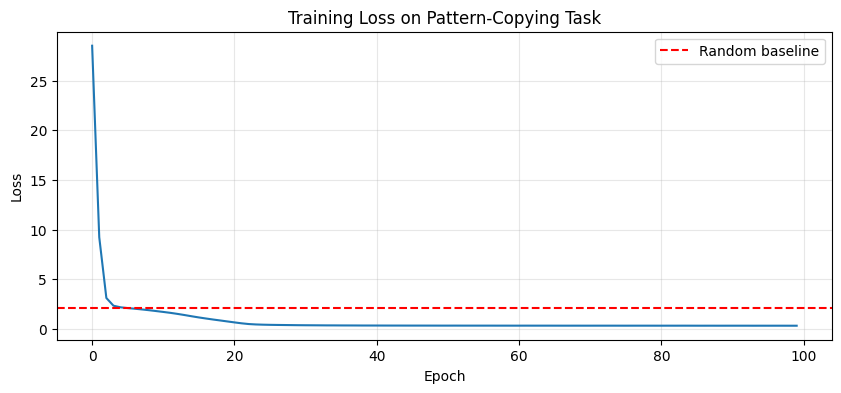

In [11]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss on Pattern-Copying Task')
plt.axhline(y=np.log(VOCAB_SIZE), color='r', linestyle='--', label='Random baseline')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# The model should achieve much lower loss than random because patterns are predictable

### Visualizing Real Attention Patterns

Now let's look at what attention patterns actually emerged. We'll feed in a sequence with a repeated pattern and see what each head learned to focus on.

Test sequence: [5, 7, 7, 5, 7, 7, 5, 7, 7, 5, 7, 7, 5, 7, 7, 5, 7, 7, 5, 7, 7, 5, 7]


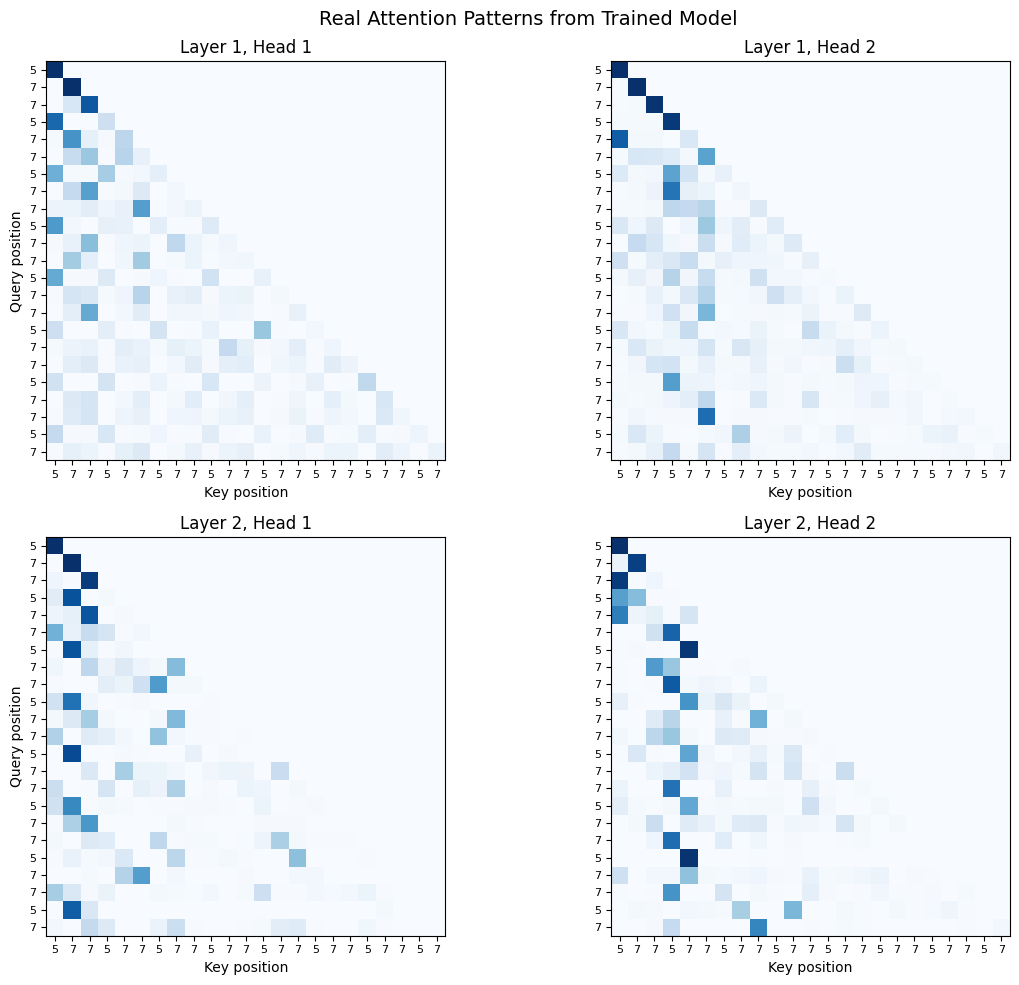


Look for:
  - Previous token patterns (diagonal stripe)
  - Pattern-matching (attention to earlier occurrences of same token)
  - Heads specializing in different behaviors


In [12]:
# Generate a test sequence and extract attention weights
model.eval()
test_seq = train_data[0:1, :-1]  # Single sequence
print(f"Test sequence: {test_seq[0].tolist()}")

with torch.no_grad():
    _ = model(test_seq)
    attention_weights = model.get_attention_weights()

# Visualize attention patterns for each layer and head
num_layers = len(attention_weights)
num_heads = attention_weights[0].shape[1]

fig, axes = plt.subplots(num_layers, num_heads, figsize=(6*num_heads, 5*num_layers))
if num_layers == 1:
    axes = axes.reshape(1, -1)
if num_heads == 1:
    axes = axes.reshape(-1, 1)

seq_labels = [str(x) for x in test_seq[0].tolist()]

for layer_idx, layer_attn in enumerate(attention_weights):
    for head_idx in range(num_heads):
        ax = axes[layer_idx, head_idx]
        attn = layer_attn[0, head_idx].numpy()  # (seq_len, seq_len)
        
        im = ax.imshow(attn, cmap='Blues', vmin=0, vmax=1)
        ax.set_title(f'Layer {layer_idx+1}, Head {head_idx+1}', fontsize=12)
        ax.set_xlabel('Key position')
        if head_idx == 0:
            ax.set_ylabel('Query position')
        ax.set_xticks(range(len(seq_labels)))
        ax.set_yticks(range(len(seq_labels)))
        ax.set_xticklabels(seq_labels, fontsize=8)
        ax.set_yticklabels(seq_labels, fontsize=8)

plt.suptitle('Real Attention Patterns from Trained Model', fontsize=14)
plt.tight_layout()
plt.show()

print("\nLook for:")
print("  - Previous token patterns (diagonal stripe)")
print("  - Pattern-matching (attention to earlier occurrences of same token)")
print("  - Heads specializing in different behaviors")

### Interpreting the Real Patterns

What you're seeing is actual learned behavior, not idealized diagrams. A few things to notice:

1. **Noisier than theory**: Real attention patterns aren't perfectly clean. Small models with limited training show messier patterns than the idealized versions.

2. **Specialization emerges**: Different heads often learn different functions. One might focus on the previous token while another looks for pattern matches.

3. **The task shapes the patterns**: Because we trained on repeating sequences, the model learns to exploit that structure. On different data, different patterns would emerge.

4. **Scale matters**: Larger models trained on more data develop cleaner, more interpretable circuits. The patterns you see in GPT-3 are sharper versions of what emerges here.

This is the reality of mechanistic interpretability. The clean concepts from the theory section manifest as noisier but still recognizable patterns in real models.